# Getting Started

In [1]:
import pandas as pd
import numpy as np
import pyPLS

# For plotting
import matplotlib.pyplot as plt
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

The use of the pyPLS package is exemplified through a multivariate calibration problem. 



The data used here is contained in an Excel file in two different spreadsheets. Pandas require `xlrd`package in order to be able to read Excel files. Makes sure you have it installed before running the notebook.

In [2]:
spectra = pd.read_excel("./data/Dataset - Raman.xlsx", sheet_name='Spectra')
spectra.head()

,Sample ID,Day,3600,3599,3598,3597,3596,3595,3594,3593,...,209,208,207,206,205,204,203,202,201,200
0,c001,0,0.111387,0.109760,0.108720,0.107833,0.107440,0.107937,0.109487,0.111787,...,18.77450,18.517401,18.249001,17.965799,17.67520,17.36940,17.039301,16.682501,16.30480,15.90060
1,c002,0,0.098637,0.099247,0.099943,0.100553,0.101227,0.102110,0.103247,0.104527,...,9.58046,9.444070,9.302040,9.152570,8.99965,8.83900,8.665690,8.478440,8.28037,8.06848
2,c003,0,0.117060,0.118077,0.119367,0.120787,0.122423,0.124447,0.126867,0.129623,...,13.34890,13.156100,12.953900,12.740300,12.51980,12.28760,12.038200,11.770000,11.48650,11.18480
3,c004,0,0.082307,0.080150,0.078457,0.076860,0.075643,0.075217,0.075677,0.076783,...,7.60757,7.527250,7.447610,7.366390,7.28964,7.21012,7.119560,7.016400,6.90600,6.78177
4,c005,0,0.102087,0.101557,0.101037,0.100387,0.099727,0.099273,0.099020,0.098890,...,8.64230,8.523190,8.399160,8.268500,8.13504,7.99464,7.842540,7.677540,7.50266,7.31490


In [3]:
metadata = pd.read_excel("./data/Dataset - Raman.xlsx", sheet_name='Metadata')
metadata.head()

,Sample ID,Day,Lambda,Kappa,Iota,Mu,Nu
0,c001,0,72.483902,1.760540,17.611200,0.00000,0.078920
1,c002,0,54.533798,20.182501,15.873800,0.00000,2.986440
2,c003,0,54.558201,13.312200,19.847099,4.21324,0.494593
3,c004,0,36.446098,56.727402,3.225920,0.00000,0.000000
4,c005,0,36.489101,43.308701,6.041920,8.45358,0.833451


# PCA of the Spectra

In [4]:
print(pyPLS.pca.__doc__)


    Principal component analysis
        Parameters:
            X: {N, P} array like
                a table of N observations (rows) and P variables (columns) - The explanatory variables,
            a: The number of component to be fitted
            scaling: float, optional
                A number typically between 0.0 and 1.0 corresponding to the scaling, typical example are
                0.0 corresponds to mean centring
                0.5 corresponds to Pareto scaling
                1.0 corresponds to unit variance scaling

        Returns
        -------
        out : a pca object with ncp components
            Attributes:
                ncp: number of components fitted
                T :  scores table
                P :  loadings table
                E :  residual table
                R2X: Part of variance of X explained by individual components
                R2Xcum: Total variance explained by all the components

            methods:
            scores(n), loadin

In [5]:
X = spectra[spectra.columns[2:]].values
pca = pyPLS.pca(X, 2, scaling=0.)
pca.summary()

Summary of input table
----------------------
Observations: 128
Variables: 3401
Missing values: 0 (0.0%)

Summary of PCA:
---------------
Number of components: 2
Total Variance explained: 99.5%
Variance explained by component:
    - Component 1 : 98.9%
    - Component 2 : 0.6%


Adding the scores to the dataframe containing the metadata will ease the plot od the scores according to the metadata.

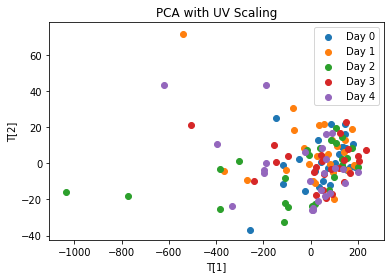

In [6]:
metadata['T[1]'] = pca.T[:,0]
metadata['T[2]'] = pca.T[:,1]
for name, group in metadata.groupby('Day'):
    plt.scatter(group['T[1]'], group['T[2]'], label='Day '+ str(name) )
plt.xlabel('T[1]')
plt.ylabel('T[2]')
plt.title("PCA with UV Scaling")
plt.legend();

In [7]:
pca = pyPLS.pca(X, 2, scaling=1.)
pca.summary()

Summary of input table
----------------------
Observations: 128
Variables: 3401
Missing values: 0 (0.0%)

Summary of PCA:
---------------
Number of components: 2
Total Variance explained: 94.8%
Variance explained by component:
    - Component 1 : 90.10000000000001%
    - Component 2 : 4.7%


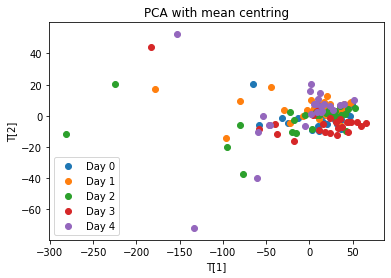

In [8]:
metadata['T[1]'] = pca.T[:,0]
metadata['T[2]'] = pca.T[:,1]
for name, group in metadata.groupby('Day'):
    plt.scatter(group['T[1]'], group['T[2]'], label='Day '+ str(name) )
plt.xlabel('T[1]')
plt.ylabel('T[2]')
plt.title("PCA with mean centring")
plt.legend();

For both PCA, the first PC explains more than 94% of the variance. Let's have a look what it looks like by plotting the loading for the PCA with meancentring.

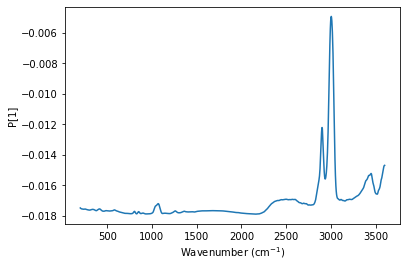

In [9]:
plt.plot(spectra.columns[2:], pca.P[:,0])
plt.xlabel('Wavenumber ($cm^{-1}$)')
plt.ylabel('P[1]');

# PLS Regression

We want to be able to predict the Kappa parameter given in the metadata table. So me define the response variable using:

In [10]:
Y = metadata['Kappa'].values

In [11]:
print(pyPLS.pls.__doc__)


    This is the classic multivariate NIPALS PLS algorithm.
    Parameters:
        X: {N, P} array like
            a table of N observations (rows) and P variables (columns) - The explanatory variables,
        Y: {N, Q} array like
            a table of N observations (rows) and Q variables (columns) - The dependent variables,
        a: int
            the number of PLS component to be fitted
        scaling: float, optional
            A number typically between 0.0 and 1.0 corresponding to the scaling, typical example are
            0.0 corresponds to mean centring
            0.5 corresponds to Pareto scaling
            1.0 corresponds to unit variance scaling
        cvfold: int, optional
            the number of folds in the cross-validation - default is 7

        Returns
        -------
        out : a pls2 object with a components
            Attributes:
                W : PLS weights table
                T : PLS scores table
                P : PLS loadings table
    

In [12]:
pls = pyPLS.pls(X, Y, ncp=5, scaling=0., cvfold=7)
pls.summary()

----------------------
Summary of input table
----------------------
Observations: 128
Predictor Variables (X): 3401
Response Variables (Y): 1
Missing values in X: 0 (0.0%)
Missing values in Y: 0 (0.0%)
---------------
Summary of PLS:
---------------
Fitted using pls
Penalisation: NA
Number of components: 5
Determination coefficient (R2Y): 0.953
Modeled variance in X: 0.999
Cross-validation:
Number of fold: 7
Cumulative Q2Y: 0.943


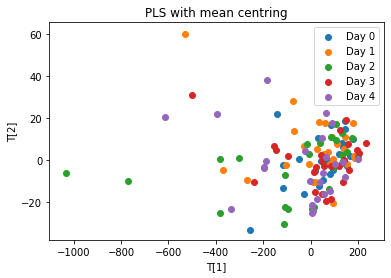

In [13]:
metadata['T[1]'] = pls.T[:,0]
metadata['T[2]'] = pls.T[:,1]
for name, group in metadata.groupby('Day'):
    plt.scatter(group['T[1]'], group['T[2]'], label='Day '+ str(name) )
plt.xlabel('T[1]')
plt.ylabel('T[2]')
plt.title("PLS with mean centring")
plt.legend();

### Model fit and cross-validation

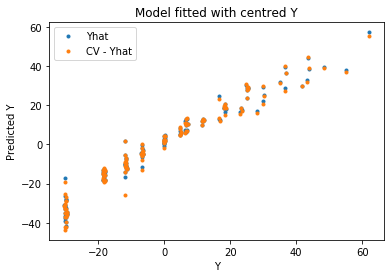

In [35]:
plt.plot(pls.Y, pls.Yhat, '.', label='Yhat')
plt.plot(pls.Y, pls.Yhatcv, '.', label='CV - Yhat')
plt.legend()
plt.xlabel('Y')
plt.ylabel('Predicted Y')
plt.title("Model fitted with centred Y");

### Prediction

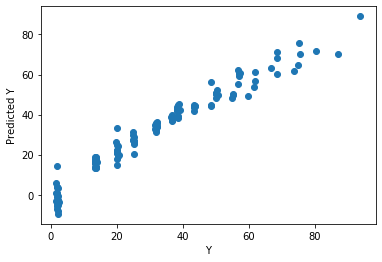

In [29]:
Yhat = pls.predict(X)
plt.scatter(Y, Yhat)
plt.xlabel('Y')
plt.ylabel('Predicted Y');

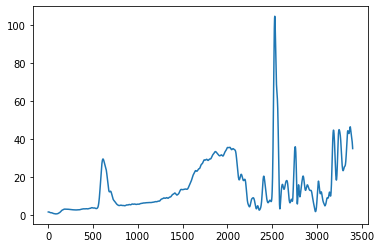

## Residual of X

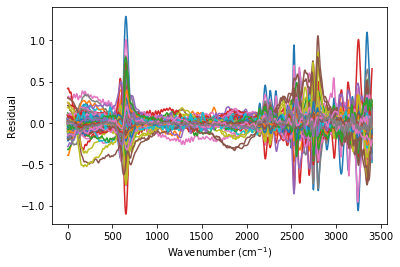

In [25]:
E = pls.X - pls.T @ pls.P.T
plt.plot(E.T);
plt.xlabel('Wavenumber ($cm^{-1}$)')
plt.ylabel('Residual');

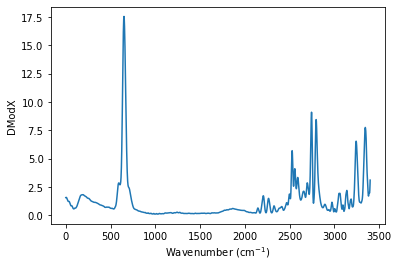

In [26]:
DModX_Variables = np.sum(E*E, axis=0)
plt.plot(DModX_Variables)
plt.xlabel('Wavenumber ($cm^{-1}$)')
plt.ylabel('DModX');

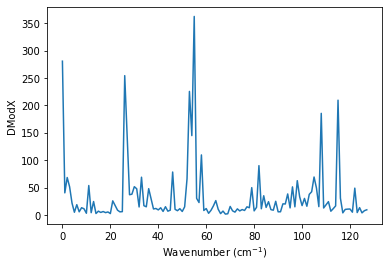

In [27]:
DModX_Observations = np.sum(E*E, axis=1)
plt.plot(DModX_Observations)
plt.xlabel('Wavenumber ($cm^{-1}$)')
plt.ylabel('DModX');